In [3]:
import csv
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 10})

compositionality_sample_ids = [
    0,1,2,5,6,7,8,9,11,12,14,15,17,18,19,20,21,24,26,29,30,32,33,34,35,37,39,43,45,47,48,50,51,52,53,54,56,57,59,60,64,66,67,
    71,79,80,85,87,89,90,91,92,94,98,99,100,101,102,104,105,106,107,108,109,112,115,117,120,122,123,124,125,126,127,129,137,139,140,141,142,145,146,147,151,153,154,
    157,158,160,161,162,165,166,167,168,169,170,171,175,177,178,179,180,181,183,184,185,186,194,195,196,197,202,205,207,212,213,216,225,231,236,240,243,244,248,250,251,252,256,
    259,261,265,266,269,270,271,272,273,278,279,283,285,288,289,290,291,294,297,301,302,306,308,309,317,328,337,341,349,357,360,366,368,369,370,372,378,379,380,389,391,397
]

In [4]:
# load the finetuned scores

scores = []
with open('./finetuned_itm_scores.csv', 'r') as f:
    reader = csv.reader(f)
    reader.__next__()
    for row in reader:
        # [id, id, c0_i0,c0_i1,c1_i0,c1_i1]
        scores.append({'id': row[1], 'c0_i0': float(row[2]), 'c0_i1': float(row[3]), 'c1_i0': float(row[4]), 'c1_i1': float(row[5])})


In [9]:
# load the original scores

# with open('./flava_itm_scores.json', 'r') as f:
with open('./flava_vanilla_itm_scores.json', 'r') as f:
    scores = json.load(f)

In [116]:
# # remove the samples not in the compositionality subset

# scores = [s for s in scores if int(s['id']) in compositionality_sample_ids]
# print(len(scores))

171


In [10]:
def text_correct(result):
    return result["c0_i0"] > result["c1_i0"] and result["c1_i1"] > result["c0_i1"]

def image_correct(result):
    return result["c0_i0"] > result["c0_i1"] and result["c1_i1"] > result["c1_i0"]

def group_correct(result):
    return image_correct(result) and text_correct(result)

def get_mean_diff(key1, key2):
    return sum([abs(score[key1] - score[key2]) for score in scores]) / len(scores)

text_correct_count = 0
image_correct_count = 0
group_correct_count = 0
for result in scores:
  text_correct_count += 1 if text_correct(result) else 0
  image_correct_count += 1 if image_correct(result) else 0
  group_correct_count += 1 if group_correct(result) else 0

denominator = len(scores)
print("text score:", text_correct_count / denominator)
print("image score:", image_correct_count / denominator)
print("group score:", group_correct_count / denominator)


text score: 0.0
image score: 0.17
group score: 0.0


In [5]:
print("image mean diff:", get_mean_diff("c0_i0", "c0_i1") + get_mean_diff("c1_i0", "c1_i1"))
print("text mean diff:", get_mean_diff("c0_i0", "c1_i0") + get_mean_diff("c0_i1", "c1_i1"))

image mean diff: 0.3210830776331932
text mean diff: 0.17066261901691177


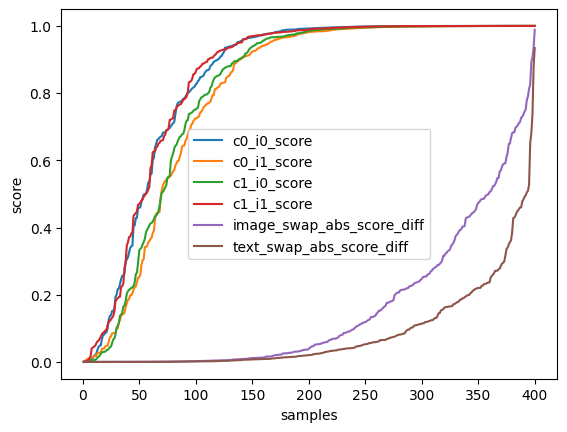

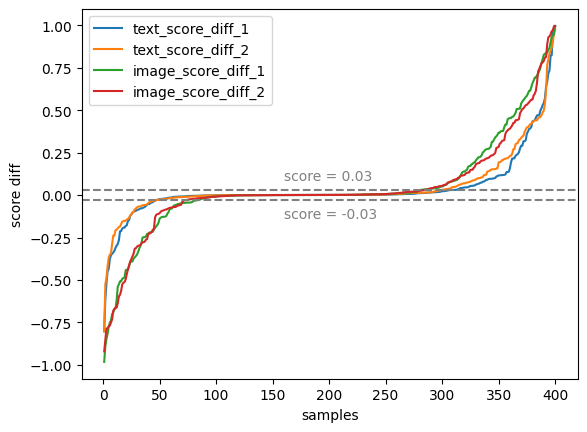

400


In [110]:
itm_scores_df = pd.DataFrame(scores)
indices = [i + 1 for i in range(len(scores))]

image_swap_diff = [ (abs(x["c0_i0"] - x["c0_i1"]) + abs(x["c1_i1"] - x["c1_i0"])) / 2 for x in scores]
text_swap_diff = [ (abs(x["c0_i0"] - x["c1_i0"]) + abs(x["c1_i1"] - x["c0_i1"])) / 2 for x in scores]

plt.plot(indices, np.sort(itm_scores_df["c0_i0"]), label="c0_i0_score")
plt.plot(indices, np.sort(itm_scores_df["c0_i1"]), label="c0_i1_score")
plt.plot(indices, np.sort(itm_scores_df["c1_i0"]), label="c1_i0_score")
plt.plot(indices, np.sort(itm_scores_df["c1_i1"]), label="c1_i1_score")
plt.plot(indices, np.sort(image_swap_diff), label="image_swap_abs_score_diff")
plt.plot(indices, np.sort(text_swap_diff), label="text_swap_abs_score_diff")

# plt.axhline(y=0.99, color='grey', linestyle='--')
# plt.text(0.5, 0.96, 'score = 0.99', color='grey', ha='left', va='top')
plt.xlabel("samples")
plt.ylabel("score")
# plt.title("ITM scores")
plt.legend()
plt.show()
plt.close()


plt.plot(indices, np.sort(itm_scores_df["c0_i0"] - itm_scores_df["c1_i0"]), label="text_score_diff_1")
plt.plot(indices, np.sort(itm_scores_df["c1_i1"] - itm_scores_df["c0_i1"]), label="text_score_diff_2")
plt.plot(indices, np.sort(itm_scores_df["c0_i0"] - itm_scores_df["c0_i1"]), label="image_score_diff_1")
plt.plot(indices, np.sort(itm_scores_df["c1_i1"] - itm_scores_df["c1_i0"]), label="image_score_diff_2")

plt.axhline(y=0.03, color='grey', linestyle='--')
plt.axhline(y=-0.03, color='grey', linestyle='--')
plt.text(160, 0.15, 'score = 0.03', color='grey', ha='left', va='top')
plt.text(160, -0.07, 'score = -0.03', color='grey', ha='left', va='top')



plt.xlabel("samples")
plt.ylabel("score diff")
# plt.title("Difference in ITM scores when comparing (correct - wrong)")
plt.legend()
plt.show()
plt.close()

# text_score_avg_diff = [ ((x["c0_i0"] - x["c1_i0"]) + (x["c1_i1"] - x["c0_i1"])) / 2 for x in scores]
# image_score_avg_diff = [ ((x["c0_i0"] - x["c0_i1"]) + (x["c1_i1"] - x["c1_i0"])) / 2 for x in scores]

# text_score_abs_avg_diff = [ (abs(x["c0_i0"] - x["c1_i0"]) + abs(x["c1_i1"] - x["c0_i1"])) / 2 for x in scores]
# image_score_abs_avg_diff = [ (abs(x["c0_i0"] - x["c0_i1"]) + abs(x["c1_i1"] - x["c1_i0"])) / 2 for x in scores]

# plt.plot(indices, np.sort(text_score_abs_avg_diff), label="image_score_abs_diff")
# plt.plot(indices, np.sort(image_score_abs_avg_diff), label="text_score_abs_diff")
# plt.plot(indices, np.sort(text_score_avg_diff), label="image_score_diff")
# plt.plot(indices, np.sort(image_score_avg_diff), label="text_score_diff")
# plt.xlabel("sample id")
# plt.ylabel("score")
# plt.title("ITM score differences")
# plt.legend()
# plt.show()
# plt.close()

# plot the difference of a score if I swap the image or swap the text


# plt.xlabel("samples")
# plt.ylabel("score diff")
# plt.title("Abs difference in ITM score when swapping image or text")
# plt.legend()
# plt.show()
# plt.close()

print(len(scores))